Loading data from ../data/bhopal_hourly.json...
Found parameters in JSON: ['ALLSKY_SFC_SW_DWN', 'ALLSKY_KT', 'T2M', 'RH2M', 'WS10M']
Detected Hourly data format (YYYYMMDDHH).

Data processing complete. Valid Rows: 476 (Dropped 340 rows with NaNs)

First 5 rows of processed data:
                     Temperature  Humidity  Irradiance  Clearness_Index  \
Timestamp                                                                 
2020-05-15 05:00:00        28.28     37.94       29.05             0.30   
2020-05-15 06:00:00        29.90     33.86      208.57             0.53   
2020-05-15 07:00:00        33.85     25.10      416.92             0.62   
2020-05-15 08:00:00        36.52     20.52      626.53             0.68   
2020-05-15 09:00:00        38.56     18.21      799.25             0.71   

                     Wind_Speed  Target_Next_Hour_Irradiance  
Timestamp                                                     
2020-05-15 05:00:00        2.81                       208.57  
2020-

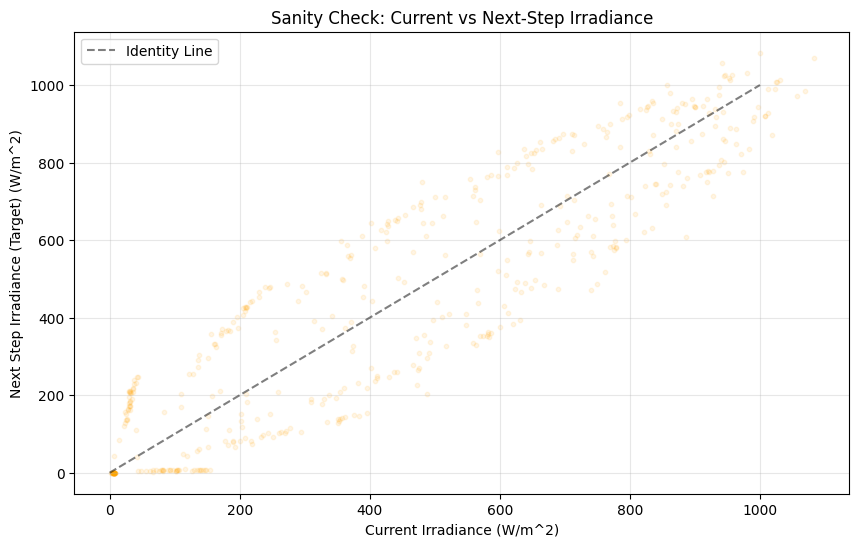

In [1]:
import pandas as pd
import json
import os
import sys
import subprocess

# Check for matplotlib and auto-install if missing
try:
    import matplotlib.pyplot as plt
    PLOT_AVAILABLE = True
except ImportError:
    print("Warning: 'matplotlib' not found. Attempting to install automatically...")
    try:
        # Use subprocess to install pip package within the script
        subprocess.check_call([sys.executable, "-m", "pip", "install", "matplotlib"])
        import matplotlib.pyplot as plt
        PLOT_AVAILABLE = True
        print("Successfully installed 'matplotlib'.")
    except Exception as e:
        PLOT_AVAILABLE = False
        print(f"Automatic installation failed: {e}")
        print("Sanity check plot will be skipped. Please run 'pip install matplotlib' in your terminal.")

# --- Configuration ---
DATA_PATH = '../data/bhopal_hourly.json'

# Key mapping: NASA Parameter Name -> Readable Column Name
PARAM_MAPPING = {
    'T2M': 'Temperature',
    'RELHUM2M': 'Humidity',
    'RH2M': 'Humidity',       # Found in your JSON
    'ALLSKY_SFC_SW_DWN': 'Irradiance',  # Found in your JSON (but might be -999)
    'ALLSKY_KT': 'Clearness_Index',
    'CLOUD_AMT': 'Cloud_Cover',
    'WS10M': 'Wind_Speed'
}

def load_nasa_power_json(file_path):
    """
    Loads NASA POWER JSON and converts it to a clean Pandas DataFrame.
    """
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"Data file not found at: {os.path.abspath(file_path)}")

    print(f"Loading data from {file_path}...")
    
    with open(file_path, 'r') as f:
        raw_data = json.load(f)

    # NASA POWER data structure check
    if 'properties' not in raw_data or 'parameter' not in raw_data['properties']:
        raise ValueError("JSON structure does not match expected NASA POWER format (properties -> parameter).")

    parameters = raw_data['properties']['parameter']
    available_keys = list(parameters.keys())
    
    print(f"Found parameters in JSON: {available_keys}")

    # Build DataFrame
    data_dict = {}
    
    for nasa_key, readable_name in PARAM_MAPPING.items():
        if nasa_key in parameters:
            # Create a series for each parameter
            series = pd.Series(parameters[nasa_key])
            
            # Convert -999 (NASA error code) to NaN immediately
            series = series.replace(-999, float('nan'))
            data_dict[readable_name] = series

    df = pd.DataFrame(data_dict)
    
    if df.empty:
        raise ValueError("No data could be extracted. Check if parameter names match JSON keys.")

    # Index handling
    first_idx = str(df.index[0])
    
    if len(first_idx) == 8:
        print("Detected Daily data format (YYYYMMDD).")
        date_fmt = '%Y%m%d'
    elif len(first_idx) == 10:
        print("Detected Hourly data format (YYYYMMDDHH).")
        date_fmt = '%Y%m%d%H'
    elif len(first_idx) == 12:
        print("Detected Sub-hourly data format (YYYYMMDDHHMM).")
        date_fmt = '%Y%m%d%H%M'
    else:
        print(f"Warning: Unknown date format length ({len(first_idx)}). Trying standard pandas parsing.")
        date_fmt = None 

    try:
        df.index = pd.to_datetime(df.index, format=date_fmt)
    except ValueError as e:
        print(f"Error parsing dates with format {date_fmt}. First key: {first_idx}")
        raise e

    df.index.name = 'Timestamp'
    return df

# --- Execution ---

try:
    # 1. Load Data
    df = load_nasa_power_json(DATA_PATH)

    # 2. Check Data Quality (Cols that are 100% NaN)
    cols_all_nan = df.columns[df.isna().all()].tolist()
    if cols_all_nan:
        print(f"\n[Warning] The following columns are 100% missing (NaN) and will be dropped:")
        print(f"   -> {cols_all_nan}")
        
        if 'Irradiance' in cols_all_nan:
            print("   [NOTE] Your source file contains 'ALLSKY_SFC_SW_DWN' but all values are -999.")
            print("   The script will continue with Weather data, but Solar targets cannot be generated.")
            
        df = df.drop(columns=cols_all_nan)
    
    # 3. Sort by Time
    df = df.sort_index()

    # 4. Create Next-Step Target (Only if Irradiance exists)
    if 'Irradiance' in df.columns:
        df['Target_Next_Hour_Irradiance'] = df['Irradiance'].shift(-1)
    else:
        print("\nSkipping target generation: 'Irradiance' data is missing.")

    # 5. Drop Missing Values
    initial_len = len(df)
    df_clean = df.dropna()
    dropped_count = initial_len - len(df_clean)
    
    print(f"\nData processing complete. Valid Rows: {len(df_clean)} (Dropped {dropped_count} rows with NaNs)")

    if len(df_clean) > 0:
        print("\nFirst 5 rows of processed data:")
        print(df_clean.head())

        # 6. Plotting
        if PLOT_AVAILABLE:
            plt.figure(figsize=(10, 6))
            
            if 'Irradiance' in df_clean.columns and 'Target_Next_Hour_Irradiance' in df_clean.columns:
                # Standard Solar Plot
                plt.scatter(df_clean['Irradiance'], df_clean['Target_Next_Hour_Irradiance'], 
                            alpha=0.1, s=10, c='orange')
                plt.title('Sanity Check: Current vs Next-Step Irradiance')
                plt.xlabel('Current Irradiance (W/m^2)')
                plt.ylabel('Next Step Irradiance (Target) (W/m^2)')
                plt.plot([0, 1000], [0, 1000], 'k--', alpha=0.5, label='Identity Line')
            elif 'Temperature' in df_clean.columns:
                # Fallback Plot (Weather only)
                plt.plot(df_clean.index, df_clean['Temperature'], label='Temperature')
                if 'Humidity' in df_clean.columns:
                    plt.plot(df_clean.index, df_clean['Humidity'], label='Humidity', alpha=0.7)
                plt.title('Weather Data Overview (Irradiance Missing)')
                plt.xlabel('Time')
                plt.ylabel('Value')
            
            plt.legend()
            plt.grid(True, alpha=0.3)
            plt.show()
    else:
        print("\n[Error] No valid rows remain after processing. Please check if your JSON contains valid data.")

except Exception as e:
    print(f"\nAn error occurred:\n{e}")